# Project 3: Web APIs & NLP

_Author: Choo Wende_

_Date: 28 Jul 2022_

---

## Background




Many countries have shift their approach to classify COVID-19 as endemic. As with many countries, Australia's tourism has been crippled in the last two years. With the easing of travel restrictions to and from Australia as of 6 Jul 2022 ([source](https://www.homeaffairs.gov.au/covid19/entering-and-leaving-australia)), there is a need to boost its tourism sector. Some of the uncertainties that is affecting tourism is as follows([source](https://www.tra.gov.au/international/international-tourism-forecasts/international-tourism-forecasts)):
1. risk of further outbreaks
2. travellers' concern around safety and health
3. availability of long-haul international flights. 


## Problem Statement

The project is assigned to a team of analysts in Tourism Australia, an Australian Government agency responsible for promoting Australian locations as business and leisure travel destinations, to promote tourism in Australia post-Covid. As Australia has scenic cross-city roads, the project targets at travellers who enjoy having roadtrips and explore means to encourage them to come to Australia. The project will develop a classification model to classify submissions into two shortlisted subreddits. The model will help the agency to identify which subreddit to review on various travel related topics. It will also help travellers to decide which subreddits to post their submissions for discussion during itinerary planning. The findings from the project will be presented to Tourism Australia management for support to implement the proposal and model. 

The project aims to:
- Shortlist two subreddits that are related to the problem statement for analysis. 
- Create a text classifier to determine whether a reddit post would be classified into the two shortlisted Subreddit groups.
- By using the Reddit API, submmissions on these two subreddits will be scraped, processed and used to build our NLP classifier. This classifier model will enable potential travellers to decide which subreddits to discussed online, research and plan itineraries based on their desired objectives.
    - Two models will be developed: a logistic regression and a multinomial naive Bayes classifier.
    - The model will also help the Tourism Australia to identify which subreddit to review given the list of topics of interest, e.g. flight discounts, car rental concerns etc.
- The project will be measuring the success of our classifier model by looking at several metrics, including accuracy, specificity, sensitivity and ROC AUC scores.

## Executive Summary



1. The project explore data scraped from five subreddits (AustraliaTravel, roadtrip, TravelHacks, TravelNoPics, Travel). TravelHacks & roadtrip were shortlisted due to comparable number of unique submissions, similar submissions frequency and substantial number of members.
2. Rows with deleted post, removed submissions, contained empty string and duplicated were dropped. 
3. From TravelHacks, key discussions revolves around 'flight'. 
4. From roadtrip, 'road', 'drive' and 'car' were discussed frequently. 
5. The sentiment scores for submissions in both subreddits were highly positive. 
6. Three models were developed:
    - Base model: Logistics Regression Model without Optimisation (logreg_base)
    - Logistics Regression Model with Cvec/Tvec (gs_logreg_model)
    - Naive-Bayes Model with Cvec/Tvec (gs_nb_model)
7. The gs_logreg_model provide the highest test accuracy and ROC AUC score of 92% and 97% respectively. Hence, it was recommended to be deployed online for travellers to identify which subreddit to post their queries or research on itinerary. 
8. The top 5 important features use to classify the respective subreddits are shown in the table below. This means that the probability of a submission classifying in the respective subreddit increase with the increase of the number of words in each group.

|TravelHacks|roadtrip|
|-|-|
|flight|road|
|travel|drive|
|book|roadtrip|
|ticket|stop|
|airline|route|

9. The project identify the various topics and proposals in each subreddits for Tourism Australia to review to attract travellers and promote roadtrips in Australia. 
    - TravelHacks: flight deals & availability, car rental cost & trustworthiness, covid testing, vaccination, travel insurance
    - roadtrip: safety, stops/detours, attractions, vehicle types.

## Content

The project was seperated into the following seperate notebooks:

**Part 1**: Webscrapping & Data Cleaning 
1. [Webscrapping](#1.-Webscrapping)
    - API Set-up
    - Retrieve JSON
    - Overview of subreddits
    - Build up data set
   
2. [Data Cleaning](#2.-Data-Cleaning)
    - Clean dataframe
    - Combine and export data set
    
**Part 2**: Exploratory Data Analysis (EDA), Data Processing & Modelling
1. EDA
    - create new column combining title and selftext
    - top 10 recurring words in each subreddits
    - sentiment analysis of each subreddits

2. Data Pre-processing
    - labelling subreddits
    - removing HTML, website addresses, non-letters, stopwords
    - stemming

3. Classification Modellling
    - Baseline Accuracy
    - Base model
    - Logistic Regression Model with Cvec/Tvec
    - Naive-Bayes Model with Cvec/Tvec
    - Overview of all models
    - Evaluation
    
4. Recommendations and Future Works
    - Recommended classification model
    - Proposal to Attract Travellers
    - Future Works

5. Conclusion

**Subreddits Explored**
1. [AustraliaTravel](https://www.reddit.com/r/AustraliaTravel/)
2. [Roadtrip](https://www.reddit.com/r/roadtrip/)
3. [TravelHacks](https://www.reddit.com/r/TravelHacks/)
4. [TravelNoPics](https://www.reddit.com/r/TravelNoPics/)
5. [Travel](https://www.reddit.com/r/travel/)


## Libraries
All libraries are imported here.

In [1]:
# standard imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

#Stylistic Choice:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')


---
# Part 1: Webscrapping & Data Cleaning

## 1. Webscrapping

### API Set-up

In [2]:
# Target Web Pages:

# This is the reddit submission(reddit posts) url set up
sub_url = 'https://api.pushshift.io/reddit/search/submission'

# This is the reddit comments to posts url set up
# comment_url = 'https://api.pushshift.io/reddit/search/comment'

In [3]:
# define parameters for subreddits
params_aust_travel = {
    'subreddit':'AustraliaTravel',
    'size':100,
    # results before 20 Jul 2022
    'before': 1658305967 # utc number. use epochconverter.com to get integer
    # results after 01 Jan 2021
    # 'after': 1609430400 # utc number.
}

params_roadtrip = {
    'subreddit':'roadtrip',
    'size':100,
    # results before 20 Jul 2022
    'before': 1658305967 # utc number. use epochconverter.com to get integer
    # results after 01 Jan 2021
    # 'after': 1609430400 # utc number.
}

In [4]:
# Establishing the connection to the web page:
au_travel_sub_res = requests.get(sub_url, 
                                 params_aust_travel, 
                                 headers={'User-agent':'cwende'})
au_travel_sub_res.status_code

200

In [5]:
# Establishing the connection to the web page:
roadtrip_sub_res = requests.get(sub_url, 
                                params_roadtrip, 
                                headers={'User-agent':'cwende'})
roadtrip_sub_res.status_code

200

### Retrieve JSON

In [6]:
# Retrieve posts 
au_travel_posts = au_travel_sub_res.json()
roadtrip_posts = roadtrip_sub_res.json()

In [7]:
# check types
type(au_travel_posts)

dict

In [8]:
# display keys of posts dictionary
au_travel_posts.keys()

dict_keys(['data'])

In [9]:
# display values of posts dictionary
# Key features that the project would be interested in are: 'subreddit', 'selftext', 'title', 'created_utc'
au_travel_posts['data'][1]

{'all_awardings': [],
 'allow_live_comments': False,
 'author': 'Phase_GGG',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_unfeu',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1657773690,
 'domain': 'self.AustraliaTravel',
 'full_link': 'https://www.reddit.com/r/AustraliaTravel/comments/vynaf3/looking_for_budget_hotels_in_melbourne/',
 'gildings': {},
 'id': 'vynaf3',
 'is_created_from_ads_ui': False,
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '',
 'link_flair_richtext': [],
 'link_flair_text_color': 'dark',
 'link_flair_type': 'text',
 'locked': False,
 'media_only': False,
 'no_follow': True,
 'num_com

In [10]:
# Convert list into dataframe
au_travel_posts_df = pd.DataFrame(au_travel_posts['data'])
roadtrip_posts_df = pd.DataFrame(roadtrip_posts['data'])

In [11]:
# display dataframe columns
# Key features that the project would be interested in are: 'subreddit', 'author', 'selftext', 'title', 'created_utc'
list(roadtrip_posts_df.columns)

['all_awardings',
 'allow_live_comments',
 'author',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_type',
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'created_utc',
 'domain',
 'full_link',
 'gallery_data',
 'gildings',
 'id',
 'is_created_from_ads_ui',
 'is_crosspostable',
 'is_gallery',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'link_flair_background_color',
 'link_flair_richtext',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media_metadata',
 'media_only',
 'no_follow',
 'num_comments',
 'num_crossposts',
 'over_18',
 'parent_whitelist_status',
 'permalink',
 'pinned',
 'pwls',
 'retrieved_on',
 'score',
 'selftext',
 'send_replies',
 'spoiler',
 'stickied',
 'subreddit',
 'subreddit_id',
 'subreddit_subscribers',
 'subreddit_type',
 'thumbnail',
 'thumbnail_height',
 

In [12]:
# Interested in subreddit, selftext and title
au_travel_posts_df = au_travel_posts_df[['subreddit', 
                                         'author', 
                                         'selftext', 
                                         'title', 
                                         'created_utc']]

# Convert 'created_utc' to datetime
au_travel_posts_df['created_utc'] = pd.to_datetime(au_travel_posts_df['created_utc'], unit = 's')

# Display first 5 and last 5 of the dataframe
au_travel_posts_df

,subreddit,author,selftext,title,created_utc
0,AustraliaTravel,Peach_blossom9,hello! I'm using flight network to book a flig...,Flexible airline tickets and cancellation opti...,2022-07-20 05:48:22
1,AustraliaTravel,Phase_GGG,My GF and I are travelling to Melb in August. ...,Looking for budget hotels in Melbourne.,2022-07-14 04:41:30
2,AustraliaTravel,mcnuggie_24,So me (F21) and my partner (F22) will be trave...,"Traveling to Melb next week, where to go?",2022-07-13 12:47:03
3,AustraliaTravel,morkvei,We are going to fly long haul with Singapore A...,Flying with a baby - seat selection,2022-07-10 04:34:45
4,AustraliaTravel,nikhilsurfingaus,,QANTAS AIRBUS A350 TRAILER | FLIGHT SIMULATOR ...,2022-07-09 10:14:56
...,...,...,...,...,...
95,AustraliaTravel,Julian_Broderick,,Everyday Thang by KING Mukaitai &amp; Julian B...,2021-11-26 01:18:04
96,AustraliaTravel,L026Y,,Does anyone have a good recommendation for tra...,2021-11-22 05:26:24
97,AustraliaTravel,1sttimer_reddituser,Can I travel to Australia right now? Has they ...,Australia travel,2021-11-17 05:16:12
98,AustraliaTravel,New_Edens_Finest,While the Great Barrier Reef is the gold stand...,Best Shore Diving in Australia?,2021-11-05 23:48:22


In [13]:
# Check number of unique values.
len(au_travel_posts_df['selftext'].unique())

74

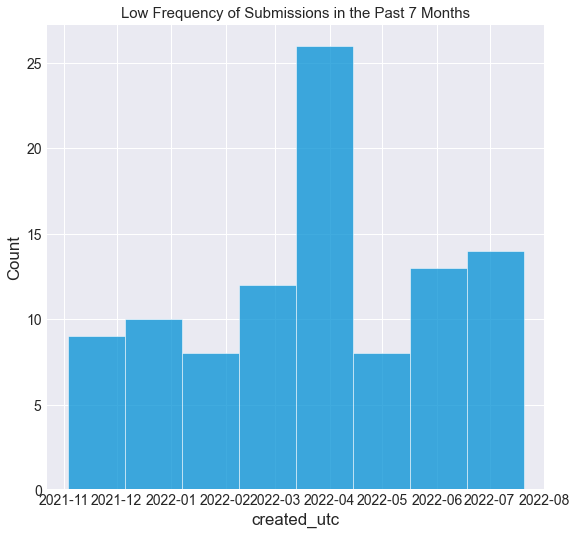

In [14]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 8))
sns.histplot(x=au_travel_posts_df['created_utc'], bins=8);
plt.title('Low Frequency of Submissions in the Past 7 Months', fontsize=15);

In [15]:
# Interested in subreddit, selftext and title
roadtrip_posts_df = roadtrip_posts_df[['subreddit', 
                                       'author', 
                                       'selftext', 
                                       'title', 
                                       'created_utc']]

# Convert 'created_utc' to datetime
roadtrip_posts_df['created_utc'] = pd.to_datetime(roadtrip_posts_df['created_utc'], unit = 's')

# Display first 5 and last 5rows of the dataframe
roadtrip_posts_df

,subreddit,author,selftext,title,created_utc
0,roadtrip,northeastbalancer,,Stopped at capitol reef national park before d...,2022-07-20 04:59:32
1,roadtrip,TeacherLady17,,Not worried about gas prices,2022-07-20 03:49:00
2,roadtrip,wackedoutbuffalo,,Does anyone know what this road sign means? Sa...,2022-07-20 03:36:28
3,roadtrip,Craig_Bryant,We're planning a Pacific Coast road trip in Se...,Pacific Coast road trip,2022-07-20 02:47:45
4,roadtrip,mattynapps,The wife and I are moving from the SF Bay Area...,Moving cross country,2022-07-20 02:44:16
...,...,...,...,...,...
95,roadtrip,tzone007,"I will be out in Washington D.C. in September,...",Things to do in either Wilmington or Atlantic ...,2022-07-16 13:49:09
96,roadtrip,Blackrazor_NZ,,Must-Visit Food Stops on 4wk DEN-PHX roadie?,2022-07-16 09:47:07
97,roadtrip,whentimerunsout,I’m driving up east coast from southern FL. I...,"What’s better Apple Maps, Google, or Waze?",2022-07-16 09:07:10
98,roadtrip,carsickcat2022,,"Took Portland aerial tram to the top, here is ...",2022-07-16 06:25:42


In [16]:
# Check number of unique values.
len(roadtrip_posts_df['selftext'].unique())

49

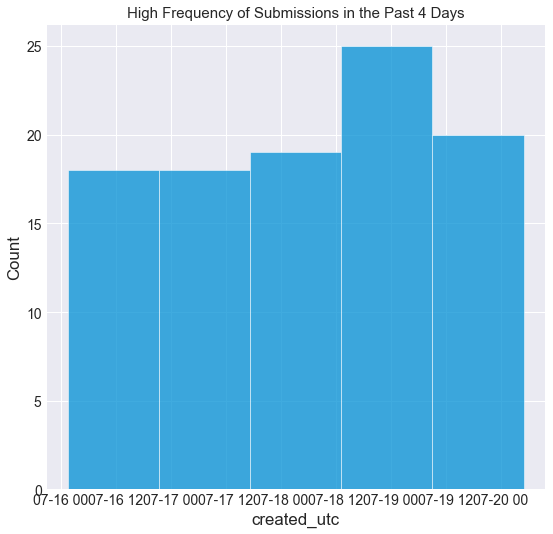

In [17]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 8))
sns.histplot(x=roadtrip_posts_df['created_utc'], bins=5);
plt.title('High Frequency of Submissions in the Past 4 Days', fontsize=15);

### Preliminary Observations
1. Key features that the project would be interested in are: `subreddit`, `selftext`, `title`, `created_utc`
2. From the 100 submissions data extracted from [AustraliaTravel](https://www.reddit.com/r/AustraliaTravel/) and [Roadtrip](https://www.reddit.com/r/roadtrip/), it the number of unique `selftext` are 74 and 49 respectively. 
3. To obtain at least 1000 entries for analysis, the project would need to extract the data at least 20 times. 
4. The cell with empty `selftext` could be because that these submissions are pictures or videos which were not extracted by the process.
5. The project will explore the following relevant subreddits before deciding on the pair of subreddits to be used for the project. 
    - [TravelHacks](https://www.reddit.com/r/TravelHacks/)
    - [TravelNoPics](https://www.reddit.com/r/TravelNoPics/)
    - [Travel](https://www.reddit.com/r/travel/)

### Define get_data function
Functions attempts to get data from url and return in dataframe.

In [18]:
def get_data(url, params):
    
    # Establishing the connection to the web page:
    res = requests.get(sub_url, 
                       params, 
                       headers={'User-agent':'cwende'})
    
    # Check response
    if res.status_code!=200:
        subreddit = params['subreddit']
        print(f'{subreddit} status code: {res.status_code}')
    
    # Retrieve JSON
    dict = res.json()
    
    # Save data to dataframe
    dict_data = pd.DataFrame(dict['data'])[['subreddit', 
                                            'author', 
                                            'selftext', 
                                            'title', 
                                            'created_utc']]
    
    # Convert 'created_utc' to datetime
    dict_data['created_utc'] = pd.to_datetime(dict_data['created_utc'], unit = 's')
       
    return dict_data

In [19]:
# define parameters for subreddits
params_TravelHacks = {
    'subreddit':'TravelHacks',
    'size':100,
    # results before 20 Jul 2022
    'before': 1658305967 # utc number. use epochconverter.com to get integer
    # results after 01 Jan 2021
    # 'after': 1609430400 # utc number.
}

# Retrieve data from url
TravelHacks_posts_df = get_data(sub_url, params_TravelHacks)

# Display first 5 and last 5rows of the dataframe
TravelHacks_posts_df

,subreddit,author,selftext,title,created_utc
0,TravelHacks,Serena_1420,[removed],Traveling to Belize with my 3 kids,2022-07-20 04:34:15
1,TravelHacks,Wisewoman24,[removed],Rental car without a registration,2022-07-20 01:58:52
2,TravelHacks,mininana,[removed],NICE HOSTELS NICE PRICE IN LOS ANGELES??,2022-07-20 01:39:31
3,TravelHacks,nickiecobble,[removed],Living in Europe affordably,2022-07-20 01:22:51
4,TravelHacks,Fantastic-Storage812,[removed],Airport tsa rules,2022-07-20 01:15:16
...,...,...,...,...,...
95,TravelHacks,RImranY,[removed],"Road Trip - Calgary, Canada to Southern Illino...",2022-07-16 20:19:23
96,TravelHacks,Alohabailey_00,,TripAdvisor plus?? Target circle is offering a...,2022-07-16 19:43:02
97,TravelHacks,Active_Amoeba6034,[removed],Miami trip advice/hacks/cheap eats?,2022-07-16 18:30:21
98,TravelHacks,Aaledrengen,I need a cheap travle destination tomorrow or ...,Cheap destination from Denmark?,2022-07-16 17:55:44


In [20]:
# Check number of unique values.
len(TravelHacks_posts_df['selftext'].unique())

53

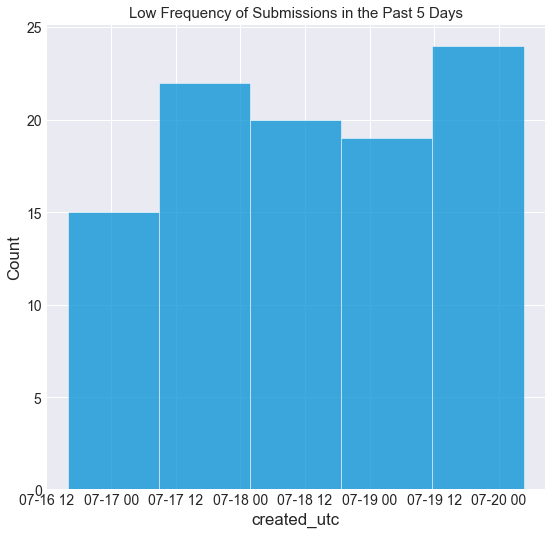

In [21]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 8))
sns.histplot(x=TravelHacks_posts_df['created_utc'], bins=5);
plt.title('Low Frequency of Submissions in the Past 5 Days', fontsize=15);

In [22]:
# define parameters for subreddits
params_TravelNoPics = {
    'subreddit':'TravelNoPics',
    'size':100,
    # results before 20 Jul 2022
    'before': 1658305967 # utc number. use epochconverter.com to get integer
    # results after this time
    # 'after': 1609430400 # utc number.
}

# Retrive data from url
TravelNoPics_posts_df = get_data(sub_url, params_TravelNoPics)

# Display first 5 and last 5rows of the dataframe
TravelNoPics_posts_df

,subreddit,author,selftext,title,created_utc
0,TravelNoPics,thegreenkite,"I was planning on visiting Czechia, France, It...","Schengen Visa question, does it matter which c...",2022-07-19 10:15:51
1,TravelNoPics,WestHillTomSawyer,[removed],"Traveling to Mazatlan, Mexico",2022-07-19 00:53:03
2,TravelNoPics,averydolohov,,Will the TSA be chill if I cover over my TSA l...,2022-07-19 00:30:49
3,TravelNoPics,External-Reserve-440,I've been planning my first solo trip (CSing/A...,How do you plan out a reasonable itinerary?,2022-07-18 16:19:08
4,TravelNoPics,Bglorieux,[removed],Our prestigious handcrafted jewelry are FREE a...,2022-07-17 20:43:31
...,...,...,...,...,...
95,TravelNoPics,Vaynar,,What are your best tricks/tips to reduce ancil...,2022-06-24 20:05:22
96,TravelNoPics,survivorcastingau,[removed],Need drone advice,2022-06-24 18:01:42
97,TravelNoPics,Level_Paramedic9404,[removed],Where can I travel with US green card and no p...,2022-06-24 17:22:52
98,TravelNoPics,financeay,[removed],How to Buy Cheap Flight Tickets all over the w...,2022-06-24 09:13:04


In [23]:
# Check number of unique values.
len(TravelNoPics_posts_df['selftext'].unique())

63

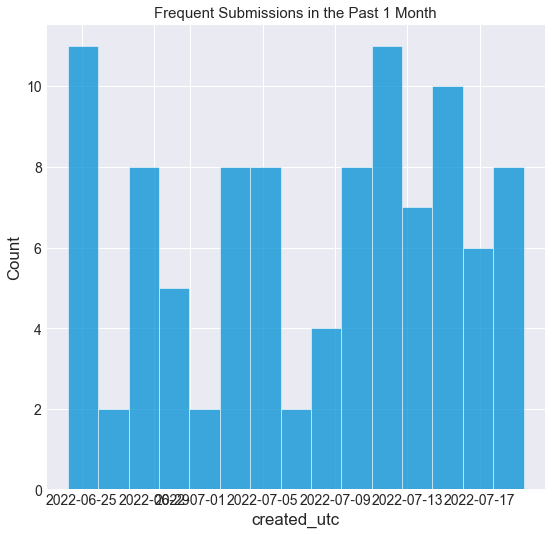

In [24]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 8))
sns.histplot(x=TravelNoPics_posts_df['created_utc'], bins=15);
plt.title('Frequent Submissions in the Past 1 Month', fontsize=15);

In [25]:
# define parameters for subreddits
params_Travel = {
    'subreddit':'Travel',
    'size':100,
    # results before 20 Jul 2022
    'before': 1658305967 # utc number. use epochconverter.com to get integer
    # results after this time
    # 'after': 1609430400 # utc number.
}

# Retrieve data from url
Travel_posts_df = get_data(sub_url, params_Travel)

# Display first 5 and last 5rows of the dataframe
Travel_posts_df

,subreddit,author,selftext,title,created_utc
0,travel,Travellagent,,Plan your next holiday with us. #holidays #tra...,2022-07-20 08:23:19
1,travel,Dawo25,Hello dear community! \nIt's that time agai...,USA Roadtrip - Need your recommendations!,2022-07-20 08:14:04
2,travel,dehjosh,I have a layover for an hour. My next flight i...,First time traveler question: What happens wit...,2022-07-20 07:59:16
3,travel,TrafficCamera90,[removed],Live m5 traffic cameras - live Traffic Cameras UK,2022-07-20 07:58:15
4,travel,GinaFredson,Over time mans greatest struggles has been acc...,Bombardment ways to subdue poverty and live in...,2022-07-20 07:51:10
...,...,...,...,...,...
94,travel,sulisaint,[removed],Travel Doubts question,2022-07-20 00:10:36
95,travel,MinnesotaNice_07,Hello everyone! Just a quick question for you ...,Question about TSA/Water Bottle,2022-07-20 00:10:27
96,travel,sulisaint,[removed],Travel Doubts,2022-07-20 00:08:57
97,travel,sulisaint,[removed],Travel Doubts,2022-07-20 00:07:27


In [26]:
# Check number of unique values.
len(Travel_posts_df['selftext'].unique())

41

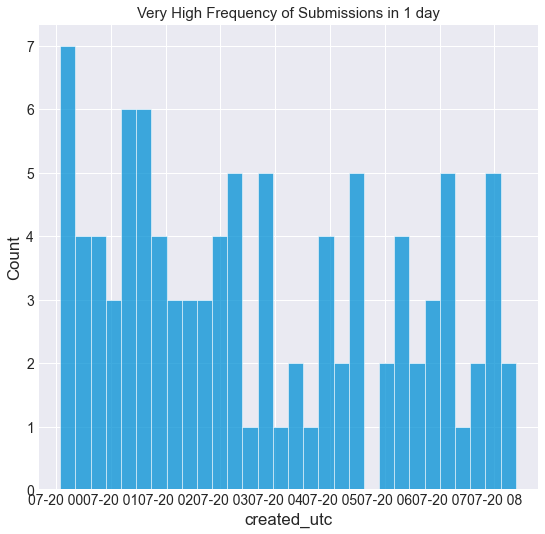

In [27]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 8))
sns.histplot(x=Travel_posts_df['created_utc'], bins=30);
plt.title('Very High Frequency of Submissions in 1 day', fontsize=15);

### Overview of all subreddits explored

|Subreddit|No. of members|No. of unique values in 'selftext'|Latest 'created_UTC'|Earliest 'created_UTC'|
|-|-|-|-|-|
|<center>AustraliaTravel <br />|<center>722|<center>74|<center>1658296102<br /> July 20, 2022 1:48:22 PM GMT+08:00|<center>1635928950<br /> November 3, 2021 4:42:30 PM GMT+08:00|
|<center>Roadtrip <br />|<center>1,900,000|<center>49|<center>1658293172<br /> July 20, 2022 12:59:32 PM GMT+08:00|<center>1657935159<br /> July 16, 2022 9:32:39 AM GMT+08:00|
|<center>TravelHacks <br />|<center>334,000|<center>53|<center>1658291655<br /> July 20, 2022 12:34:15 PM GMT+08:00|<center>1657987202<br />  July 17, 2022 12:00:02 AM GMT+08:00|
|<center>TravelNoPics <br />|<center>20,900|<center>63|<center>1658225751<br /> July 19, 2022 6:15:51 PM GMT+08:00|<center>1656049494<br /> June 24, 2022 1:44:54 PM GMT+08:002|
|<center>Travel <br />|<center>6,700,000|<center>41|<center>1658305399<br /> July 20, 2022 4:23:19 PM GMT+08:00|<center>1658275485<br /> July 20, 2022 8:04:45 AM GMT+08:00|
    

### Assessment
1. Comparing the submissions extracted for the various subreddits, the two subreddits with the highest number of unqiue values are AustraliaTravel and TravelNoPics.
2. While the number of unique submissions from AustraliaTravel is high, the subreddit is not very active as the earliest of the 100 submissions was dated 3 Nov 2021. Moreover, there are only 722 members. Hence, we will not select AustraliaTravel.
3. The project will not select TravelNoPics as well because there are other subreddits with more members, which should provide a more diversified submissions. 
4. While subreddit Travel has high frequency of submission, it is also not selected as it has the lowest number of unique values. 
5. The subreddits with the next two highest number of unique value is **roadtrip** and  **TravelHacks**. They have comparable number of unique submissions, similar submissions frequency and substantial number of members. Roadtrips may be suitable for families and ideal to explore the natural landscapes in Australia. TravelHacks should provides tips to travellers. Hence, the project will analyse these two subreddits. 






### Build up data set 

In [28]:
# input random seed
np.random.seed(42)

# Loop to retrieve posts multiple request
for i in range(30):
    print(f'Iteration: {i}')
    
    # The difference between the latest post and earliest submission is about 3 to 4 days 
    # Generate random integer represent 5-6 days.
    before_num = np.random.randint(430_000,520_000)
    print(f'before_num: {before_num}')

    # Update parameters
    params_roadtrip['before'] -= before_num    
    params_TravelHacks['before'] -= before_num
    date = params_TravelHacks['before']
    print(f'Submission before: {date}')
    
    # Retrieve data from url
    roadtrip_df = get_data(sub_url, params_roadtrip)
    TravelHacks_df = get_data(sub_url, params_TravelHacks)
        
    # Append new data to existing dataframe
    roadtrip_posts_df = pd.concat([roadtrip_posts_df, roadtrip_df])
    TravelHacks_posts_df = pd.concat([TravelHacks_posts_df, TravelHacks_df])
    
    # generate a random sleep duration to manage number of requests per second
    sleep_duration = np.random.randint(2,10)
    print(f'Sleep: {sleep_duration}s')
    time.sleep(sleep_duration)

Iteration: 0
before_num: 445795
Submission before: 1657860172
Sleep: 6s
Iteration: 1
before_num: 506820
Submission before: 1657353352
Sleep: 8s
Iteration: 2
before_num: 436265
Submission before: 1656917087
Sleep: 4s
Iteration: 3
before_num: 467194
Submission before: 1656449893
Sleep: 4s
Iteration: 4
before_num: 474131
Submission before: 1655975762
Sleep: 9s
Iteration: 5
before_num: 446023
Submission before: 1655529739
Sleep: 4s
Iteration: 6
before_num: 497221
Submission before: 1655032518
Sleep: 6s
Iteration: 7
before_num: 430769
Submission before: 1654601749
Sleep: 9s
Iteration: 8
before_num: 492955
Submission before: 1654108794
Sleep: 7s
Iteration: 9
before_num: 497969
Submission before: 1653610825
Sleep: 9s
Iteration: 10
before_num: 513104
Submission before: 1653097721
Sleep: 5s
Iteration: 11
before_num: 515305
Submission before: 1652582416
Sleep: 7s
Iteration: 12
before_num: 501932
Submission before: 1652080484
Sleep: 5s
Iteration: 13
before_num: 455658
Submission before: 165162482

In [29]:
# Check shape of dataframe
roadtrip_posts_df.shape, TravelHacks_posts_df.shape

((3099, 5), (3097, 5))

In [30]:
# reset index for dataframe.
roadtrip_posts_df = roadtrip_posts_df.reset_index(drop=True)
TravelHacks_posts_df = TravelHacks_posts_df.reset_index(drop=True)

In [31]:
# Display first 5 and last 5 rows
roadtrip_posts_df

,subreddit,author,selftext,title,created_utc
0,roadtrip,northeastbalancer,,Stopped at capitol reef national park before d...,2022-07-20 04:59:32
1,roadtrip,TeacherLady17,,Not worried about gas prices,2022-07-20 03:49:00
2,roadtrip,wackedoutbuffalo,,Does anyone know what this road sign means? Sa...,2022-07-20 03:36:28
3,roadtrip,Craig_Bryant,We're planning a Pacific Coast road trip in Se...,Pacific Coast road trip,2022-07-20 02:47:45
4,roadtrip,mattynapps,The wife and I are moving from the SF Bay Area...,Moving cross country,2022-07-20 02:44:16
...,...,...,...,...,...
3094,roadtrip,TaraBanana1806,,Sydney to Melbourne - coastal route,2022-02-01 23:35:04
3095,roadtrip,1AXC,I’m from Southern California and want to just ...,Can anyone suggest where to road trip to for g...,2022-02-01 21:33:00
3096,roadtrip,Natural-Skeptic,,Made this Poster Design and thought you guys m...,2022-02-01 21:21:47
3097,roadtrip,zebradonkey69,So my sister and her boyfriend are planning a ...,New Orleans —&gt; Denver,2022-02-01 21:05:01


In [32]:
# Display first 5 and last 5 rows
TravelHacks_posts_df

,subreddit,author,selftext,title,created_utc
0,TravelHacks,Serena_1420,[removed],Traveling to Belize with my 3 kids,2022-07-20 04:34:15
1,TravelHacks,Wisewoman24,[removed],Rental car without a registration,2022-07-20 01:58:52
2,TravelHacks,mininana,[removed],NICE HOSTELS NICE PRICE IN LOS ANGELES??,2022-07-20 01:39:31
3,TravelHacks,nickiecobble,[removed],Living in Europe affordably,2022-07-20 01:22:51
4,TravelHacks,Fantastic-Storage812,[removed],Airport tsa rules,2022-07-20 01:15:16
...,...,...,...,...,...
3092,TravelHacks,Powerful-Perception5,,Hey everybody,2022-01-28 19:07:55
3093,TravelHacks,deltaairlines293,,How to Choose the Right Indigo Career Cabin Crew,2022-01-28 13:07:47
3094,TravelHacks,DadaskiDiaries,,"Hello and TGIF, welcome. If you like nature, m...",2022-01-28 13:02:44
3095,TravelHacks,No-Connection6543,,Support me guys I'm now here,2022-01-28 13:00:32


## 2. Data Cleaning

### Cleaning Dataframe
1. For rows with null value in `selftext`, the corresponding `title` value does not seem to be useful either. Therefore, all three rows were dropped. 
2. Remove duplicates in the dataframes
3. In the `selftext`, it is observed that there are empty string, deleted post and removed submissions 
    - rows with deleted post and removed submissions will be removed.
    - rows with empty string: these submissions are likely to be pictures or videos. The title may not say much about the submission as well. Hence, these rows will be removed as well. 

In [33]:
# Check for null values
roadtrip_posts_df.isnull().sum().sort_values(ascending=False).head(20)

subreddit      0
author         0
selftext       0
title          0
created_utc    0
dtype: int64

In [34]:
# Check for null values
TravelHacks_posts_df.isnull().sum().sort_values(ascending=False).head(20)

selftext       3
subreddit      0
author         0
title          0
created_utc    0
dtype: int64

In [35]:
# Display rows with 'selftext' is null 
TravelHacks_posts_df[TravelHacks_posts_df['selftext'].isnull()]

,subreddit,author,selftext,title,created_utc
37,TravelHacks,[deleted],NaN,Hotel,2022-07-18 21:26:59
165,TravelHacks,[deleted],NaN,"PrimeDay is today - 56% off Samsonite Omni 2, ...",2022-07-12 08:27:56
1227,TravelHacks,[deleted],NaN,Have you booked your flight with Delta airways...,2022-05-13 11:39:13


In [36]:
# Display title with 'selftext' is null 
TravelHacks_posts_df[TravelHacks_posts_df['selftext'].isnull()].loc[165]['title']

'PrimeDay is today - 56% off Samsonite Omni 2, really nice deal'

In [37]:
# Display title with 'selftext' is null 
TravelHacks_posts_df[TravelHacks_posts_df['selftext'].isnull()].loc[1227]['title']

'Have you booked your flight with Delta airways? If yes then you should definitely know about Delta 24 hour cancellation.'

In [38]:
# Drop rows with null values and reset index. 
TravelHacks_posts_df = TravelHacks_posts_df.drop(index=[37, 165, 1227]).reset_index(drop=True)
TravelHacks_posts_df

,subreddit,author,selftext,title,created_utc
0,TravelHacks,Serena_1420,[removed],Traveling to Belize with my 3 kids,2022-07-20 04:34:15
1,TravelHacks,Wisewoman24,[removed],Rental car without a registration,2022-07-20 01:58:52
2,TravelHacks,mininana,[removed],NICE HOSTELS NICE PRICE IN LOS ANGELES??,2022-07-20 01:39:31
3,TravelHacks,nickiecobble,[removed],Living in Europe affordably,2022-07-20 01:22:51
4,TravelHacks,Fantastic-Storage812,[removed],Airport tsa rules,2022-07-20 01:15:16
...,...,...,...,...,...
3089,TravelHacks,Powerful-Perception5,,Hey everybody,2022-01-28 19:07:55
3090,TravelHacks,deltaairlines293,,How to Choose the Right Indigo Career Cabin Crew,2022-01-28 13:07:47
3091,TravelHacks,DadaskiDiaries,,"Hello and TGIF, welcome. If you like nature, m...",2022-01-28 13:02:44
3092,TravelHacks,No-Connection6543,,Support me guys I'm now here,2022-01-28 13:00:32


For rows with null value in `selftext`, the corresponding `title` value does not seem to be useful either. Therefore, all three rows were dropped. 

In [39]:
# drop duplicates in the dataframe 
roadtrip_posts_df.drop_duplicates(subset=['selftext','title'], inplace=True)

In [40]:
# drop duplicates in the dataframe
TravelHacks_posts_df.drop_duplicates(subset=['selftext','title'], inplace=True)

In [41]:
# check shapre of dataframe
roadtrip_posts_df.shape, TravelHacks_posts_df.shape

((3003, 5), (2792, 5))

In [42]:
# reset index for dataframe.
roadtrip_posts_df = roadtrip_posts_df.reset_index(drop=True)
TravelHacks_posts_df = TravelHacks_posts_df.reset_index(drop=True)

In [43]:
# check number of unique values
len(roadtrip_posts_df['selftext'].unique())

1205

In [44]:
# check number of unique values
len(TravelHacks_posts_df['selftext'].unique())

1415

In [45]:
# Display unique values and count. 
roadtrip_posts_df.groupby('selftext').count().sort_values(['title'], ascending=False).head(10)

,subreddit,author,title,created_utc
selftext,,,,
,1664,1664,1664,1664
[removed],130,130,130,130
[deleted],3,3,3,3
"Last summer we took a weekend trip to the coast to escape the heatwaves and wildfire smoke that occurs annually half the year in inland Northern California. We decided to take a trip to Trinidad California, a small town on the Northern Coast. The scenery was jaw dropping. Glimmering rocky shorelines, magical old growth redwood forests filled with moss and ferns. It's like the Big Sur of NorCal. A gem trip for sure if you live in Northern California. Can't wait to return next summer.",3,3,3,3
"Bought Toyota Camry Hybrid LE 2022 in October, already has 12K miles, did a round trip in March to San Antonio. Rental Cost is $1026 pick up September 11 and return car September 28.",2,2,2,2
"Im looking for someone who can help move a queen mattress from Park city to Los Angeles (Sherman Oaks). I will compensate for the move, Please DM me if interested. Thank you!",2,2,2,2
"I’ve never driven in this specific area before. Looking for recommendations for camping, sight seeing, food... all of it! \n\nDriving from Colorado Springs to Sacramento. Sadly will be on a small time crunch. \n\nAfter Sacramento I am then heading up the coast to Seaside, OR.\n\nSo excited about this! Thank you so much for your insight! 💛",1,1,1,1
"Just as the title reads, going to be driving through these two areas to visit some of my girl friends family. Wondering if anyone has any stops they recommend? I’ll be in the area for about a week so looking for some fun options.",1,1,1,1
"Just finished an incredible 6-week road trip throughout the west; Idaho, Utah, California, Nevada, and Arizona. I built a platform and kitchen in the back of my 2012 Subaru Outback and hit the road, with my girlfriend joining me for short stretches. We camped almost entirely on public land using the Dyrt, used AllTrails for finding hikes, and planned the whole trip with Furkot. \n\nI've compiled lists on our campsites and trails below, plus an outline of the whole trip in case you need some inspiration! We had to bail after Escalante because my GF got a tent-pole to the eye and needed surgery, but we're planning on tackling the Capitol Reef/Moab/Arches section later this fall. \n\nHopefully, this helps you avoid some of the hours of research needed to find good campsites and trails in the American West!\n\nRoadtrip Planner: [https://trips.furkot.com/ts/2hgjmp](https://trips.furkot.com/ts/2hgjmp)\n\nCampsites: [https://thedyrt.com/list/spring-journey](https://thedyrt.com/list/spring-journey)\n\nTrails: [https://www.alltrails.com/lists/spring-journey-full-3016a44?u=i](https://www.alltrails.com/lists/spring-journey-full-3016a44?u=i)",1,1,1,1


In [46]:
# Display unique values and count. 
TravelHacks_posts_df.groupby('selftext').count().sort_values(['title'], ascending=False).head(10)

,subreddit,author,title,created_utc
selftext,,,,
[removed],954,954,954,954
,418,418,418,418
[deleted],5,5,5,5
"Hello! I am a third year student trying to go study abroad in South Korea this summer. I have been trying to find funding, grants, and scholarships to help me go so I couldn't commit to the program until recently. \n\nBecause of that I am now looking for a good ticket price that's somewhat a decent quality flight but the price isn't looking so good right now. I'm looking for a round trip flight from DEN to ICN (United States to South Korea) arriving either on 6/24 or 6/25 and departing on 8/8 with the date for departure being pretty flexible. I've tried looking at all the good flight search website such as kayak, skyscanner, and momondo and have found some good flights that cost around $2,000-2,100 with either Korean Airline or United Airline. However, I don't know if this is the best price or if there's a chance of the price lowering more throughout the week. I have heard people say buying tickets on certain days do make a difference on the ticket price but is it true?\n\nAlthough I have had experience with buying domestic flight tickets, it was when I had a good portion of time before buying the tickets where I can compare prices and wait. This is my first time buying an international ticket so I'm a little nervous with making decisions. \n\nTo all the traveling professionals, is buying international tickets two months before leaving a bad length of time? Is it a good choice to buy the ticket now or should I wait for a few more days to monitor the price? Is there any other random tips or methods of finding a good flight ticket? Please help!",2,2,2,2
"I’m traveling on a tourist visa to Egypt for a week and my flight lands in Cairo at 11:10 (EY 653). I wanted to fly to Luxor on the same day and the domestic flight from Cairo to Luxor is at 13:55. Am I cutting it too close? \n\n1.\tI’ll have a check in baggage\n2.\tI’ll have an e-visa\n2.\tWill have to go through immigration (how long does this usually take at CAI? )\n3.\tHow long does it take to transfer to domestic terminal? \n\nI’ve another flight at 17:00 which I felt is a long wait. Any help is much appreciated, thanks!",2,2,2,2
[https://www.cybertalk.org/2022/06/28/summer-travel-8-cyber-security-tips-so-that-you-can-have-more-fun/](https://www.cybertalk.org/2022/06/28/summer-travel-8-cyber-security-tips-so-that-you-can-have-more-fun/),2,2,2,2
"I’m visiting Bend to watch Foo Fighters in October, then off to visit my step sister in California. Thinking of 10 days travel period. Any tips on where to stay, what to do etc.? I’m travelling solo and I don’t drive. Open to any type of activity. Thank you in advance (I’m travelling from the Philippines by the way hehe) 😊",1,1,1,1
"I’m planning a trip around Asia from USA both in rural and city environments. Wondering if I should get vaccinated with all the ones recommended through CDC (hep, typhoid, encephalitis)? Do you guys do it?\n\nMy Asian parents and family friends say they never have gotten them (minus the ones you get the ones as a child). Even friends who travel international frequently.",1,1,1,1
I’ve been in Italy for a week and now got a flight back to Spain and a connecting flight in Frankfurt. Do I need to fill out a passenger locator form or is having proof of a COVID vaccine enough? On my flight from USA to Spain and my flight from Spain to Italy they didn’t check for the form or proof of vaccine. It’s starting to feel like a waste of time and I can’t find the link.,1,1,1,1


In the `selftext`, it is observed that there are empty string, deleted post and removed submissions.
- rows with deleted post and removed submissions will be removed.
- rows with empty string: these submissions are likely to be pictures or videos. The title may not say much about the submission as well. Hence, these rows will be removed as well. 

In [47]:
# Remove rows with empty string, deleted post and removed submissions.
roadtrip_index = roadtrip_posts_df[(roadtrip_posts_df['selftext']=='')
                                    | (roadtrip_posts_df['selftext']=='[deleted]')
                                    | (roadtrip_posts_df['selftext']=='[removed]')].index
roadtrip_posts_df.drop(index=roadtrip_index, inplace=True)

TravelHacks_index = TravelHacks_posts_df[(TravelHacks_posts_df['selftext']=='')
                                        | (TravelHacks_posts_df['selftext']=='[deleted]')
                                        | (TravelHacks_posts_df['selftext']=='[removed]')].index
TravelHacks_posts_df.drop(index=TravelHacks_index, inplace=True)

In [48]:
roadtrip_posts_df

,subreddit,author,selftext,title,created_utc
3,roadtrip,Craig_Bryant,We're planning a Pacific Coast road trip in Se...,Pacific Coast road trip,2022-07-20 02:47:45
4,roadtrip,mattynapps,The wife and I are moving from the SF Bay Area...,Moving cross country,2022-07-20 02:44:16
5,roadtrip,veg4npoutine,"My family and I are from Calgary, Canada, and...",Ideas for a trip from Calgary to LA and Vegas?,2022-07-20 02:37:27
7,roadtrip,dustyfrothman,I'm about to start a long motorcycle road trip...,From MA to SC. Must stop places along Skyline ...,2022-07-20 00:17:37
8,roadtrip,snowboarding420,Heading south this Friday and curious which wa...,495 around DC or 15 to 17,2022-07-20 00:00:26
...,...,...,...,...,...
2990,roadtrip,_princess-galaxia_,\n\n[View Poll](https://www.reddit.com/poll/si...,Often told I drive too much. What's the averag...,2022-02-02 05:54:33
2992,roadtrip,Marokiii,Either driving time or actual distance travele...,What's your sweet spot for AVERAGE daily drivi...,2022-02-02 03:26:20
2993,roadtrip,SlothGeo,I’ve decided to take a road trip with my three...,First come/First Serve camping near Redwoods?,2022-02-02 03:22:12
2999,roadtrip,1AXC,I’m from Southern California and want to just ...,Can anyone suggest where to road trip to for g...,2022-02-01 21:33:00


In [49]:
TravelHacks_posts_df

,subreddit,author,selftext,title,created_utc
7,TravelHacks,Remarkable_Lie_8622,Have you any experience booking a roundtrip ti...,How do you book a roundtrip but a different ci...,2022-07-19 21:41:24
8,TravelHacks,kastelu,Hi everyone! Next month I'll be visiting my co...,What to do in London in 15+ hours?,2022-07-19 21:04:48
9,TravelHacks,Avocadosandtomatoes,I’m not too particular on the destination. I j...,Is there a way to search cheap flights coming ...,2022-07-19 20:39:03
10,TravelHacks,monarchal,"I just need to be there Saturday, would be nic...",Where’s the cheapest place to get a flight fro...,2022-07-19 18:45:22
11,TravelHacks,Small-Decision8803,Which would you choose for vacation? I’ve neve...,Seattle vs denver,2022-07-19 18:28:38
...,...,...,...,...,...
2772,TravelHacks,copper678,I’m looking to rent a 8 passenger van for 6 we...,Long term car rental options: Europe (Poland),2022-01-30 02:17:01
2774,TravelHacks,hypeskeptic,"I'm trying to book a flight to cancun, mexico ...",Making your own 'layover' flight worth?,2022-01-30 00:38:16
2775,TravelHacks,whatser_face,I’ll be fortunate enough to travel a lot this ...,How to get alerts for concerts/ events in diff...,2022-01-29 21:43:05
2777,TravelHacks,Baz_EP,"Hi all,\n\nWe’re planning a family trip from L...",Luggage tips,2022-01-29 18:45:05


#### Cleaning roadtrip Dataframe 
As the entries are similar in nature, duplicates are dropped. 

In [50]:
# recap on unique values and count. 
roadtrip_unique = roadtrip_posts_df.groupby('selftext').count().sort_values(['title'], ascending=False).head(10)
roadtrip_unique

,subreddit,author,title,created_utc
selftext,,,,
"Last summer we took a weekend trip to the coast to escape the heatwaves and wildfire smoke that occurs annually half the year in inland Northern California. We decided to take a trip to Trinidad California, a small town on the Northern Coast. The scenery was jaw dropping. Glimmering rocky shorelines, magical old growth redwood forests filled with moss and ferns. It's like the Big Sur of NorCal. A gem trip for sure if you live in Northern California. Can't wait to return next summer.",3,3,3,3
"Bought Toyota Camry Hybrid LE 2022 in October, already has 12K miles, did a round trip in March to San Antonio. Rental Cost is $1026 pick up September 11 and return car September 28.",2,2,2,2
"Im looking for someone who can help move a queen mattress from Park city to Los Angeles (Sherman Oaks). I will compensate for the move, Please DM me if interested. Thank you!",2,2,2,2
"\n\nDue to the wildfires in Mawona, we’re looking to change our plans and maybe do Yosemite in future years. \n\nWe fly into SF on 30th July and have to be at Caliente for a ranch stay on 2 August. We’re now thinking of doing the scenic drive on highway 1 to get us from SF to Caliente, perhaps with a couple of night stops in between. \n\nWould really welcome some suggestions of places to stop and good places/towns to spend the night. What would be ideal is if there were somewhere midway we could have a two night stop rather than two separate places, but we’re open to whatever folks would suggest!\n\nWith thanks.",1,1,1,1
"Leaving San Antonio and headed infinitely West, visiting Marfa, Big Bend, and the Universe- my girlfriend and I slept in the back of my jeep and kept going until we couldn't anymore- and we filmed the whole thing. Here's the film for those interested :) [https://youtu.be/WUMU4evKUck](https://youtu.be/WUMU4evKUck)\n\nAnything we missed? We cant wait to get back to West Texas! Where should we road trip to next?",1,1,1,1
"Later this year I’ll possibly be doing a road trip from Oregon to Texas. I wanted to go the route that takes you through Idaho, Utah, Colorado, and New Mexico on the way there. And on the way back, go through New Mexico, Arizona, Nevada, and California. I was wondering if there’s any towns or areas to stay away from along the way? Like towns with predatory cops, or areas where scams or robberies may be common? Thanks for any help.",1,1,1,1
"Later this year I'm going on my very first solo Cross-Country road trip. I have a rough plan, but I can't help but feel nervous as hell about it. Especially in terms of socializing (already a little shy and can be socially awkward depending on the day of the week lol) and what to do in between the things I plan to do. Am I just overthinking it? Any advice would be super appreciated!",1,1,1,1
"Last time I went in 2019 the pumps would always ask for a zip code when I would put my credit card in. \n\nThen I would have to go walk into the store and tell the guy "" I dont have a zip code"", then he would do something and say ""ok go ahead now"".\n\nIt really annoys when I am trying to make great time! Is there a way I can circumvent this? Could I use a dummy zip code, or is this some sort of credit card verification step that would not work with a random zip code?",1,1,1,1
"Karakoram highway is the 8th wonder of the world, it passes through mountains, rivers, deserts, farms, meadows, hills covered with snow and reaches through china border.\n\nhttps://youtube.com/shorts/IGs_SHJQe1M?feature=share",1,1,1,1


In [51]:
# Review entries with duplicated selftext.
roadtrip_posts_df[roadtrip_posts_df['selftext']==roadtrip_unique.index[0]]

,subreddit,author,selftext,title,created_utc
2229,roadtrip,Swampdoodle,Last summer we took a weekend trip to the coas...,The Most Beautiful Place I've Been,2022-03-17 23:30:45
2230,roadtrip,Swampdoodle,Last summer we took a weekend trip to the coas...,The Most Beautiful Place I've Seen,2022-03-17 23:29:17
2231,roadtrip,Swampdoodle,Last summer we took a weekend trip to the coas...,The Most Beautiful Place I've Ever Been,2022-03-17 23:25:37


In [52]:
# Review entries with duplicated selftext.
roadtrip_posts_df[roadtrip_posts_df['selftext']==roadtrip_unique.index[1]]

,subreddit,author,selftext,title,created_utc
501,roadtrip,ayamai,"Bought Toyota Camry Hybrid LE 2022 in October,...",Round Trip from Portland to Raleigh/Durham/Cha...,2022-06-23 02:50:11
502,roadtrip,ayamai,"Bought Toyota Camry Hybrid LE 2022 in October,...",Round Trip from Portland to Raleigh/Durham/Cha...,2022-06-23 02:46:25


In [53]:
# Review entries with duplicated selftext.
roadtrip_posts_df[roadtrip_posts_df['selftext']==roadtrip_unique.index[2]]

,subreddit,author,selftext,title,created_utc
539,roadtrip,bopittwistiteatit,Im looking for someone who can help move a que...,Looking for anyone making the trip from Park C...,2022-06-21 16:04:50
540,roadtrip,bopittwistiteatit,Im looking for someone who can help move a que...,Looking for anyone moving from Park City Utah ...,2022-06-21 16:03:55


In [54]:
roadtrip_posts_df.shape

(1206, 5)

In [55]:
# drop duplicates in the dataframe 
roadtrip_posts_df.drop_duplicates(subset=['selftext'], inplace=True)

As the entries are similar in nature, duplicates are dropped. 

#### Cleaning TravelHacks Dataframe
As the entries are similar in nature, duplicates are dropped. 

In [56]:
# recap on unique values and count. 
TravelHacks_unique = TravelHacks_posts_df.groupby('selftext').count().sort_values(['title'], ascending=False).head(10)
TravelHacks_unique

,subreddit,author,title,created_utc
selftext,,,,
[https://www.cybertalk.org/2022/06/28/summer-travel-8-cyber-security-tips-so-that-you-can-have-more-fun/](https://www.cybertalk.org/2022/06/28/summer-travel-8-cyber-security-tips-so-that-you-can-have-more-fun/),2,2,2,2
"I’m traveling on a tourist visa to Egypt for a week and my flight lands in Cairo at 11:10 (EY 653). I wanted to fly to Luxor on the same day and the domestic flight from Cairo to Luxor is at 13:55. Am I cutting it too close? \n\n1.\tI’ll have a check in baggage\n2.\tI’ll have an e-visa\n2.\tWill have to go through immigration (how long does this usually take at CAI? )\n3.\tHow long does it take to transfer to domestic terminal? \n\nI’ve another flight at 17:00 which I felt is a long wait. Any help is much appreciated, thanks!",2,2,2,2
"Hello! I am a third year student trying to go study abroad in South Korea this summer. I have been trying to find funding, grants, and scholarships to help me go so I couldn't commit to the program until recently. \n\nBecause of that I am now looking for a good ticket price that's somewhat a decent quality flight but the price isn't looking so good right now. I'm looking for a round trip flight from DEN to ICN (United States to South Korea) arriving either on 6/24 or 6/25 and departing on 8/8 with the date for departure being pretty flexible. I've tried looking at all the good flight search website such as kayak, skyscanner, and momondo and have found some good flights that cost around $2,000-2,100 with either Korean Airline or United Airline. However, I don't know if this is the best price or if there's a chance of the price lowering more throughout the week. I have heard people say buying tickets on certain days do make a difference on the ticket price but is it true?\n\nAlthough I have had experience with buying domestic flight tickets, it was when I had a good portion of time before buying the tickets where I can compare prices and wait. This is my first time buying an international ticket so I'm a little nervous with making decisions. \n\nTo all the traveling professionals, is buying international tickets two months before leaving a bad length of time? Is it a good choice to buy the ticket now or should I wait for a few more days to monitor the price? Is there any other random tips or methods of finding a good flight ticket? Please help!",2,2,2,2
"\n\nApologies if this has been answered here recently, but what opportunities are there out there for a British passport holder in their mid 20s. Ideally I was looking for Eurocamp work but it appears that they don’t hire British citizens anymore (obligatory frustration about brexit), I’ve done a little research into WWOOF and house siting, and would consider doing these as part of my travels but ideally I would like to earn money and meet people out there. Any suggestions would be greatly appreciated\n\nThanks in advance for any help!",1,1,1,1
I’m planning a trip to Australia and as the flight is usually in two parts I want to find a country I can travel around for a couple of weeks on the way there and on the way back so that there is no sense of ‘stop over’.\nAny recommendations?,1,1,1,1
"I’m planning to head to Qatar this summer and on my returning flight, my only options are to pass through a US city, Seattle, LAX, Boston or Chicago, and then to my hometown in Calgary, Canada. I do not know what to expect as this will be my first time travelling alone, and do not know what to expect when I am going to be clearing customs and immigration when I land in the US. Would I have to re-check in my luggage after I pass US immigration before my flight to Canada? Thank you and Any help and advice will be appreciated!",1,1,1,1
I’m planning to go there around Autumn 2022 but I just want to asses my options first before I do.,1,1,1,1
I’m planning on traveling to Germany this summer but i am a little bit horrified at the outrageous plane tickets. Is there any cheaper alternative? Cheap air far

In [57]:
# Review entries with duplicated selftext.
TravelHacks_posts_df[TravelHacks_posts_df['selftext']==TravelHacks_unique.index[0]]

,subreddit,author,selftext,title,created_utc
348,TravelHacks,Admirable_Baker,[https://www.cybertalk.org/2022/06/28/summer-t...,Summer travel: 8 cyber security tips so that y...,2022-06-30 18:40:01
382,TravelHacks,Admirable_Baker,[https://www.cybertalk.org/2022/06/28/summer-t...,Summer travel: 8 cyber security tips so that y...,2022-06-29 04:02:19


In [58]:
# Review entries with duplicated selftext.
TravelHacks_posts_df[TravelHacks_posts_df['selftext']==TravelHacks_unique.index[1]]

,subreddit,author,selftext,title,created_utc
810,TravelHacks,iam_spr,I’m traveling on a tourist visa to Egypt for a...,Egypt - Cairo to Luxor,2022-06-05 16:33:12
811,TravelHacks,iam_spr,I’m traveling on a tourist visa to Egypt for a...,Cairo to Luxor,2022-06-05 16:29:28


In [59]:
# Review entries with duplicated selftext.
TravelHacks_posts_df[TravelHacks_posts_df['selftext']==TravelHacks_unique.index[2]]

,subreddit,author,selftext,title,created_utc
1425,TravelHacks,GgomoSmol,Hello! I am a third year student trying to go ...,I commit to my study abroad program late and n...,2022-04-29 21:53:37
1426,TravelHacks,GgomoSmol,Hello! I am a third year student trying to go ...,"Commit to study abroad last minute, struggling...",2022-04-29 21:19:18


In [60]:
# drop duplicates in the dataframe 
TravelHacks_posts_df.drop_duplicates(subset=['selftext'], inplace=True)

As the entries are similar in nature, duplicates are dropped. 

### Combine Dataframe and save as csv file

In [61]:
# Display and do final check on the train data set before saving
roadtrip_posts_df

,subreddit,author,selftext,title,created_utc
3,roadtrip,Craig_Bryant,We're planning a Pacific Coast road trip in Se...,Pacific Coast road trip,2022-07-20 02:47:45
4,roadtrip,mattynapps,The wife and I are moving from the SF Bay Area...,Moving cross country,2022-07-20 02:44:16
5,roadtrip,veg4npoutine,"My family and I are from Calgary, Canada, and...",Ideas for a trip from Calgary to LA and Vegas?,2022-07-20 02:37:27
7,roadtrip,dustyfrothman,I'm about to start a long motorcycle road trip...,From MA to SC. Must stop places along Skyline ...,2022-07-20 00:17:37
8,roadtrip,snowboarding420,Heading south this Friday and curious which wa...,495 around DC or 15 to 17,2022-07-20 00:00:26
...,...,...,...,...,...
2990,roadtrip,_princess-galaxia_,\n\n[View Poll](https://www.reddit.com/poll/si...,Often told I drive too much. What's the averag...,2022-02-02 05:54:33
2992,roadtrip,Marokiii,Either driving time or actual distance travele...,What's your sweet spot for AVERAGE daily drivi...,2022-02-02 03:26:20
2993,roadtrip,SlothGeo,I’ve decided to take a road trip with my three...,First come/First Serve camping near Redwoods?,2022-02-02 03:22:12
2999,roadtrip,1AXC,I’m from Southern California and want to just ...,Can anyone suggest where to road trip to for g...,2022-02-01 21:33:00


In [62]:
# Display and do final check on the train data set before saving
TravelHacks_posts_df

,subreddit,author,selftext,title,created_utc
7,TravelHacks,Remarkable_Lie_8622,Have you any experience booking a roundtrip ti...,How do you book a roundtrip but a different ci...,2022-07-19 21:41:24
8,TravelHacks,kastelu,Hi everyone! Next month I'll be visiting my co...,What to do in London in 15+ hours?,2022-07-19 21:04:48
9,TravelHacks,Avocadosandtomatoes,I’m not too particular on the destination. I j...,Is there a way to search cheap flights coming ...,2022-07-19 20:39:03
10,TravelHacks,monarchal,"I just need to be there Saturday, would be nic...",Where’s the cheapest place to get a flight fro...,2022-07-19 18:45:22
11,TravelHacks,Small-Decision8803,Which would you choose for vacation? I’ve neve...,Seattle vs denver,2022-07-19 18:28:38
...,...,...,...,...,...
2772,TravelHacks,copper678,I’m looking to rent a 8 passenger van for 6 we...,Long term car rental options: Europe (Poland),2022-01-30 02:17:01
2774,TravelHacks,hypeskeptic,"I'm trying to book a flight to cancun, mexico ...",Making your own 'layover' flight worth?,2022-01-30 00:38:16
2775,TravelHacks,whatser_face,I’ll be fortunate enough to travel a lot this ...,How to get alerts for concerts/ events in diff...,2022-01-29 21:43:05
2777,TravelHacks,Baz_EP,"Hi all,\n\nWe’re planning a family trip from L...",Luggage tips,2022-01-29 18:45:05


In [63]:
# Combine both dataframe
combined_posts_df = pd.concat([TravelHacks_posts_df, roadtrip_posts_df])

In [64]:
# Reset index of combined posts
combined_posts_df.reset_index(drop=True, inplace=True)

In [65]:
# Check shape of dataframe
combined_posts_df.shape

(2614, 5)

In [66]:
# Save cleaned dataframe as csv file.
combined_posts_df.to_csv('../datasets/combined_posts.csv', index=False)

# <center> **End of Notebook**